In [ ]:
#imports
import gdown
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
url = "https://drive.google.com/drive/folders/1aulFmTOH2YDHAUsclBRdcEQCgxslKbh2"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/9417_data/X_test.npy',
 '/content/9417_data/X_train.npy',
 '/content/9417_data/y_train.npy']

In [ ]:
#read_data
x_test_path = '/content/9417_data/X_test.npy'
y_train_path = '/content/9417_data/y_train.npy'
x_train_path = '/content/9417_data/X_train.npy'

# Load the data
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_test = np.load(x_test_path)

In [ ]:
def analyze_data(X_train, X_test, y_train):
    analysis = {
        "X_train_shape": X_train.shape,
        "X_test_shape": X_test.shape,
        "y_train_shape": y_train.shape,
        "X_train_missing_values": np.isnan(X_train).sum(),
        "X_test_missing_values": np.isnan(X_test).sum(),
        "y_train_missing_values": np.isnan(y_train).sum(),
    }
    return analysis

# Perform the analysis
analysis_result = analyze_data(X_train, X_test, y_train)
analysis_result

{'X_train_shape': (1000, 111),
 'X_test_shape': (700, 111),
 'y_train_shape': (1000, 11),
 'X_train_missing_values': 9450,
 'X_test_missing_values': 6524,
 'y_train_missing_values': 0}

In [ ]:
#data cleaning using median for numerical features
#impute all missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_imputed_missing_values = np.isnan(X_train_imputed).sum()
X_test_imputed_missing_values = np.isnan(X_test_imputed).sum()

X_train_imputed_missing_values, X_test_imputed_missing_values

(0, 0)

In [ ]:
#data cleaning using KNN for numerical features
# KNN Imputer initialization
knn_imputer = KNNImputer(n_neighbors=5)
# Impute missing values in X_train
X_train_imputed_knn = knn_imputer.fit_transform(X_train)
X_test_imputed_knn = knn_imputer.transform(X_test)
X_train_imputed_knn_missing_values = np.isnan(X_train_imputed_knn).sum()
X_test_imputed_knn_missing_values = np.isnan(X_test_imputed_knn).sum()

X_train_imputed_knn_missing_values, X_test_imputed_knn_missing_values

(0, 0)

This part is EDA analysis, responded by Andrew. also add extra data cleaning

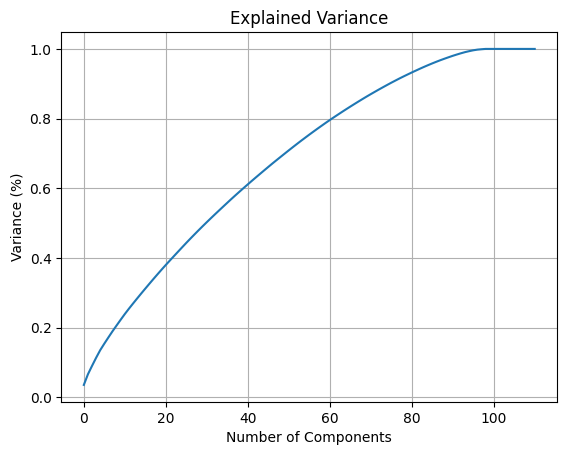

In [ ]:
#For this case l will use KNN as pre_transformed data
# Standardize the data before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_knn)
X_test_scaled = scaler.transform(X_test_imputed_knn)

# PCA Analysis
pca = PCA().fit(X_train_scaled)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_var_per = explained_variance_ratio * 100
explained_variance_sequence = sorted(list(explained_var_per), reverse=True)

near_zero_variance_threshold = 1e-5
near_zero_variances = [variance for variance in explained_variance_sequence if variance < near_zero_variance_threshold]

# Number of components to keep (those above the threshold)
n_components_to_keep = len(explained_variance_sequence) - len(near_zero_variances)

# Redefine PCA with the selected number of components
pca_reduced = PCA(n_components=n_components_to_keep)

# Apply PCA to the scaled data
X_train_pca = pca_reduced.fit_transform(X_train_scaled)
X_test_pca = pca_reduced.transform(X_test_scaled)

# Number of features before and after PCA
original_features = X_train_scaled.shape[1]
reduced_features = X_train_pca.shape[1]

print(f"Number of features before PCA: {original_features}")
print(f"Number of features after PCA: {reduced_features}")

Number of features before PCA: 111
Number of features after PCA: 99


In [ ]:
#print all features that need to be removed
features_below_threshold_indices = [i for i, variance in enumerate(explained_variance_ratio) if variance * 100 < near_zero_variance_threshold]

# Printing the indices of features with variance below the threshold
print(f"Number of features before PCA: {original_features}")
print(f"Number of features after PCA: {reduced_features}")
print(f"Features with variance below the threshold ({near_zero_variance_threshold}):")
for index in features_below_threshold_indices:
    print(f"feature_{index}")

Number of features before PCA: 111
Number of features after PCA: 99
Features with variance below the threshold (1e-05):
feature_99
feature_100
feature_101
feature_102
feature_103
feature_104
feature_105
feature_106
feature_107
feature_108
feature_109
feature_110


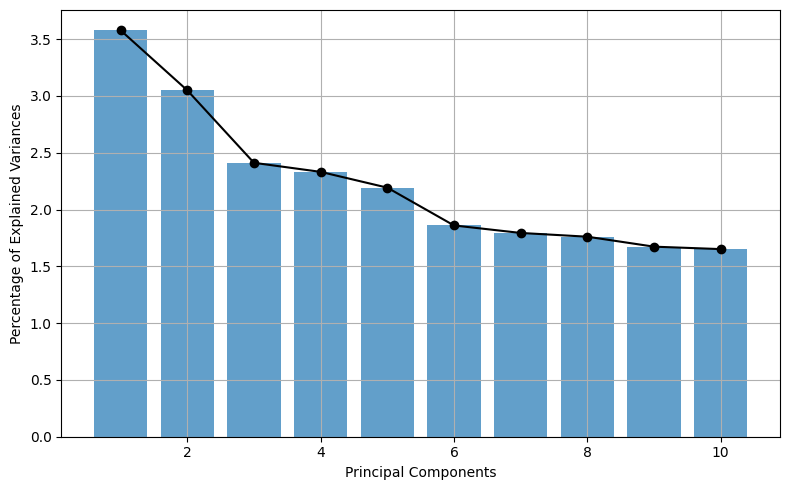

In [ ]:
#using PCA to find top10 PC
explained_variance_percentage_reduced = pca_reduced.explained_variance_ratio_[:10] * 100

# Creating a scree plot for the top 10 principal components
plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), explained_variance_percentage_reduced, alpha=0.7, align='center')
plt.plot(range(1, 11), explained_variance_percentage_reduced, 'o-', color='black')

# Add labels and title
plt.ylabel('Percentage of Explained Variances')
plt.xlabel('Principal Components')
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
#using GB boosting classifier to find feature importance
from sklearn.ensemble import GradientBoostingClassifier

# Redefine the Gradient Boosting model
X_train_df = pd.DataFrame(X_train_scaled, columns=[f'feature_{i}' for i in range(X_train_scaled.shape[1])])
gbc = GradientBoostingClassifier(n_estimators=100, random_state=0)

gbc.fit(X_train_df, y_train.argmax(axis=1))

# Getting feature importances from the Gradient Boosting model
feature_importances = gbc.feature_importances_
# Output the feature importances
feature_importances_ordered = sorted(zip(X_train_df.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features = feature_importances_ordered[:10]  # Show top 10 features

top_features

[('feature_85', 0.06239067262750877),
 ('feature_86', 0.06147293437549107),
 ('feature_88', 0.061177489318850496),
 ('feature_83', 0.06115827992568629),
 ('feature_90', 0.054082389898570046),
 ('feature_89', 0.04821927654574657),
 ('feature_0', 0.04129966813025973),
 ('feature_35', 0.04068431711744673),
 ('feature_82', 0.031771195588773574),
 ('feature_33', 0.030890668349509803)]

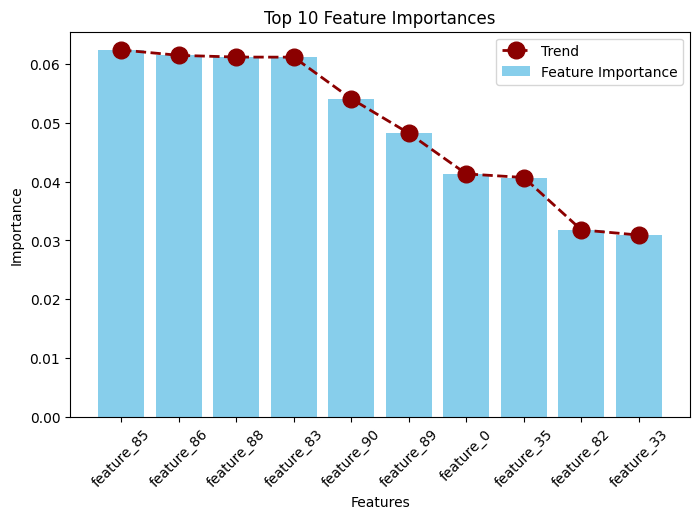

In [ ]:
# Extracting features and their corresponding importance
features, importances = zip(*top_features)

# Plotting the feature importances
plt.figure(figsize=(8, 5))
plt.bar(features, importances, color='skyblue', label='Feature Importance')
plt.plot(features, importances, color='darkred', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Trend')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=45)
plt.legend()
plt.show()

unsupervised method(check data ifself, no prediction):
PCA Explained Variance: PCA looks at the variance in the data. We refer to how much of the total dataset variance is captured by that principal component.  

supervised method(need involve y_train)
Gradient Boosting Feature Importance: This indicates how valuable each feature was in the construction of the boosted decision trees within the model. It's based on how much each feature contributes to decreasing the model's error.

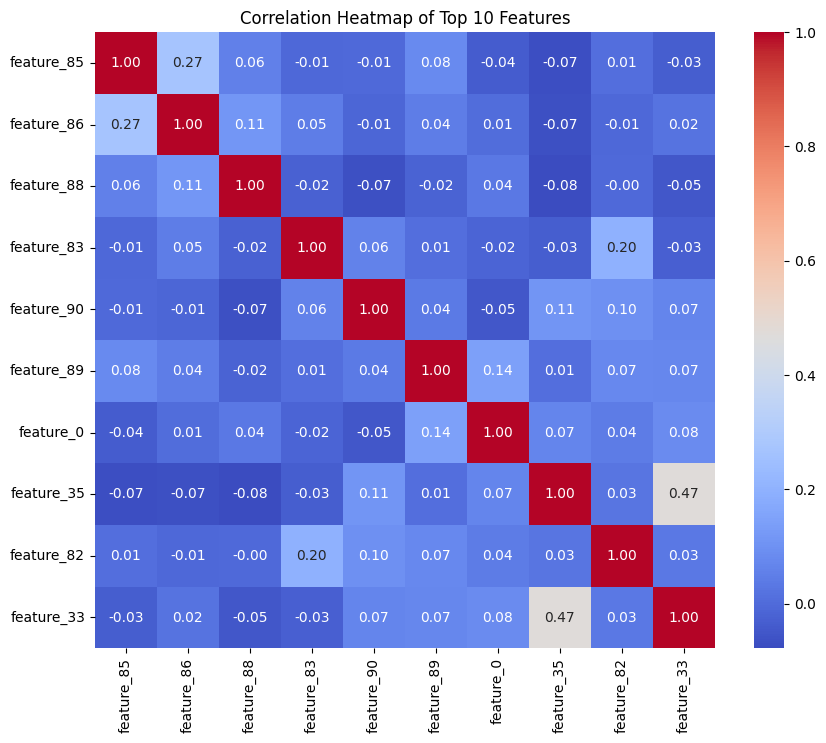

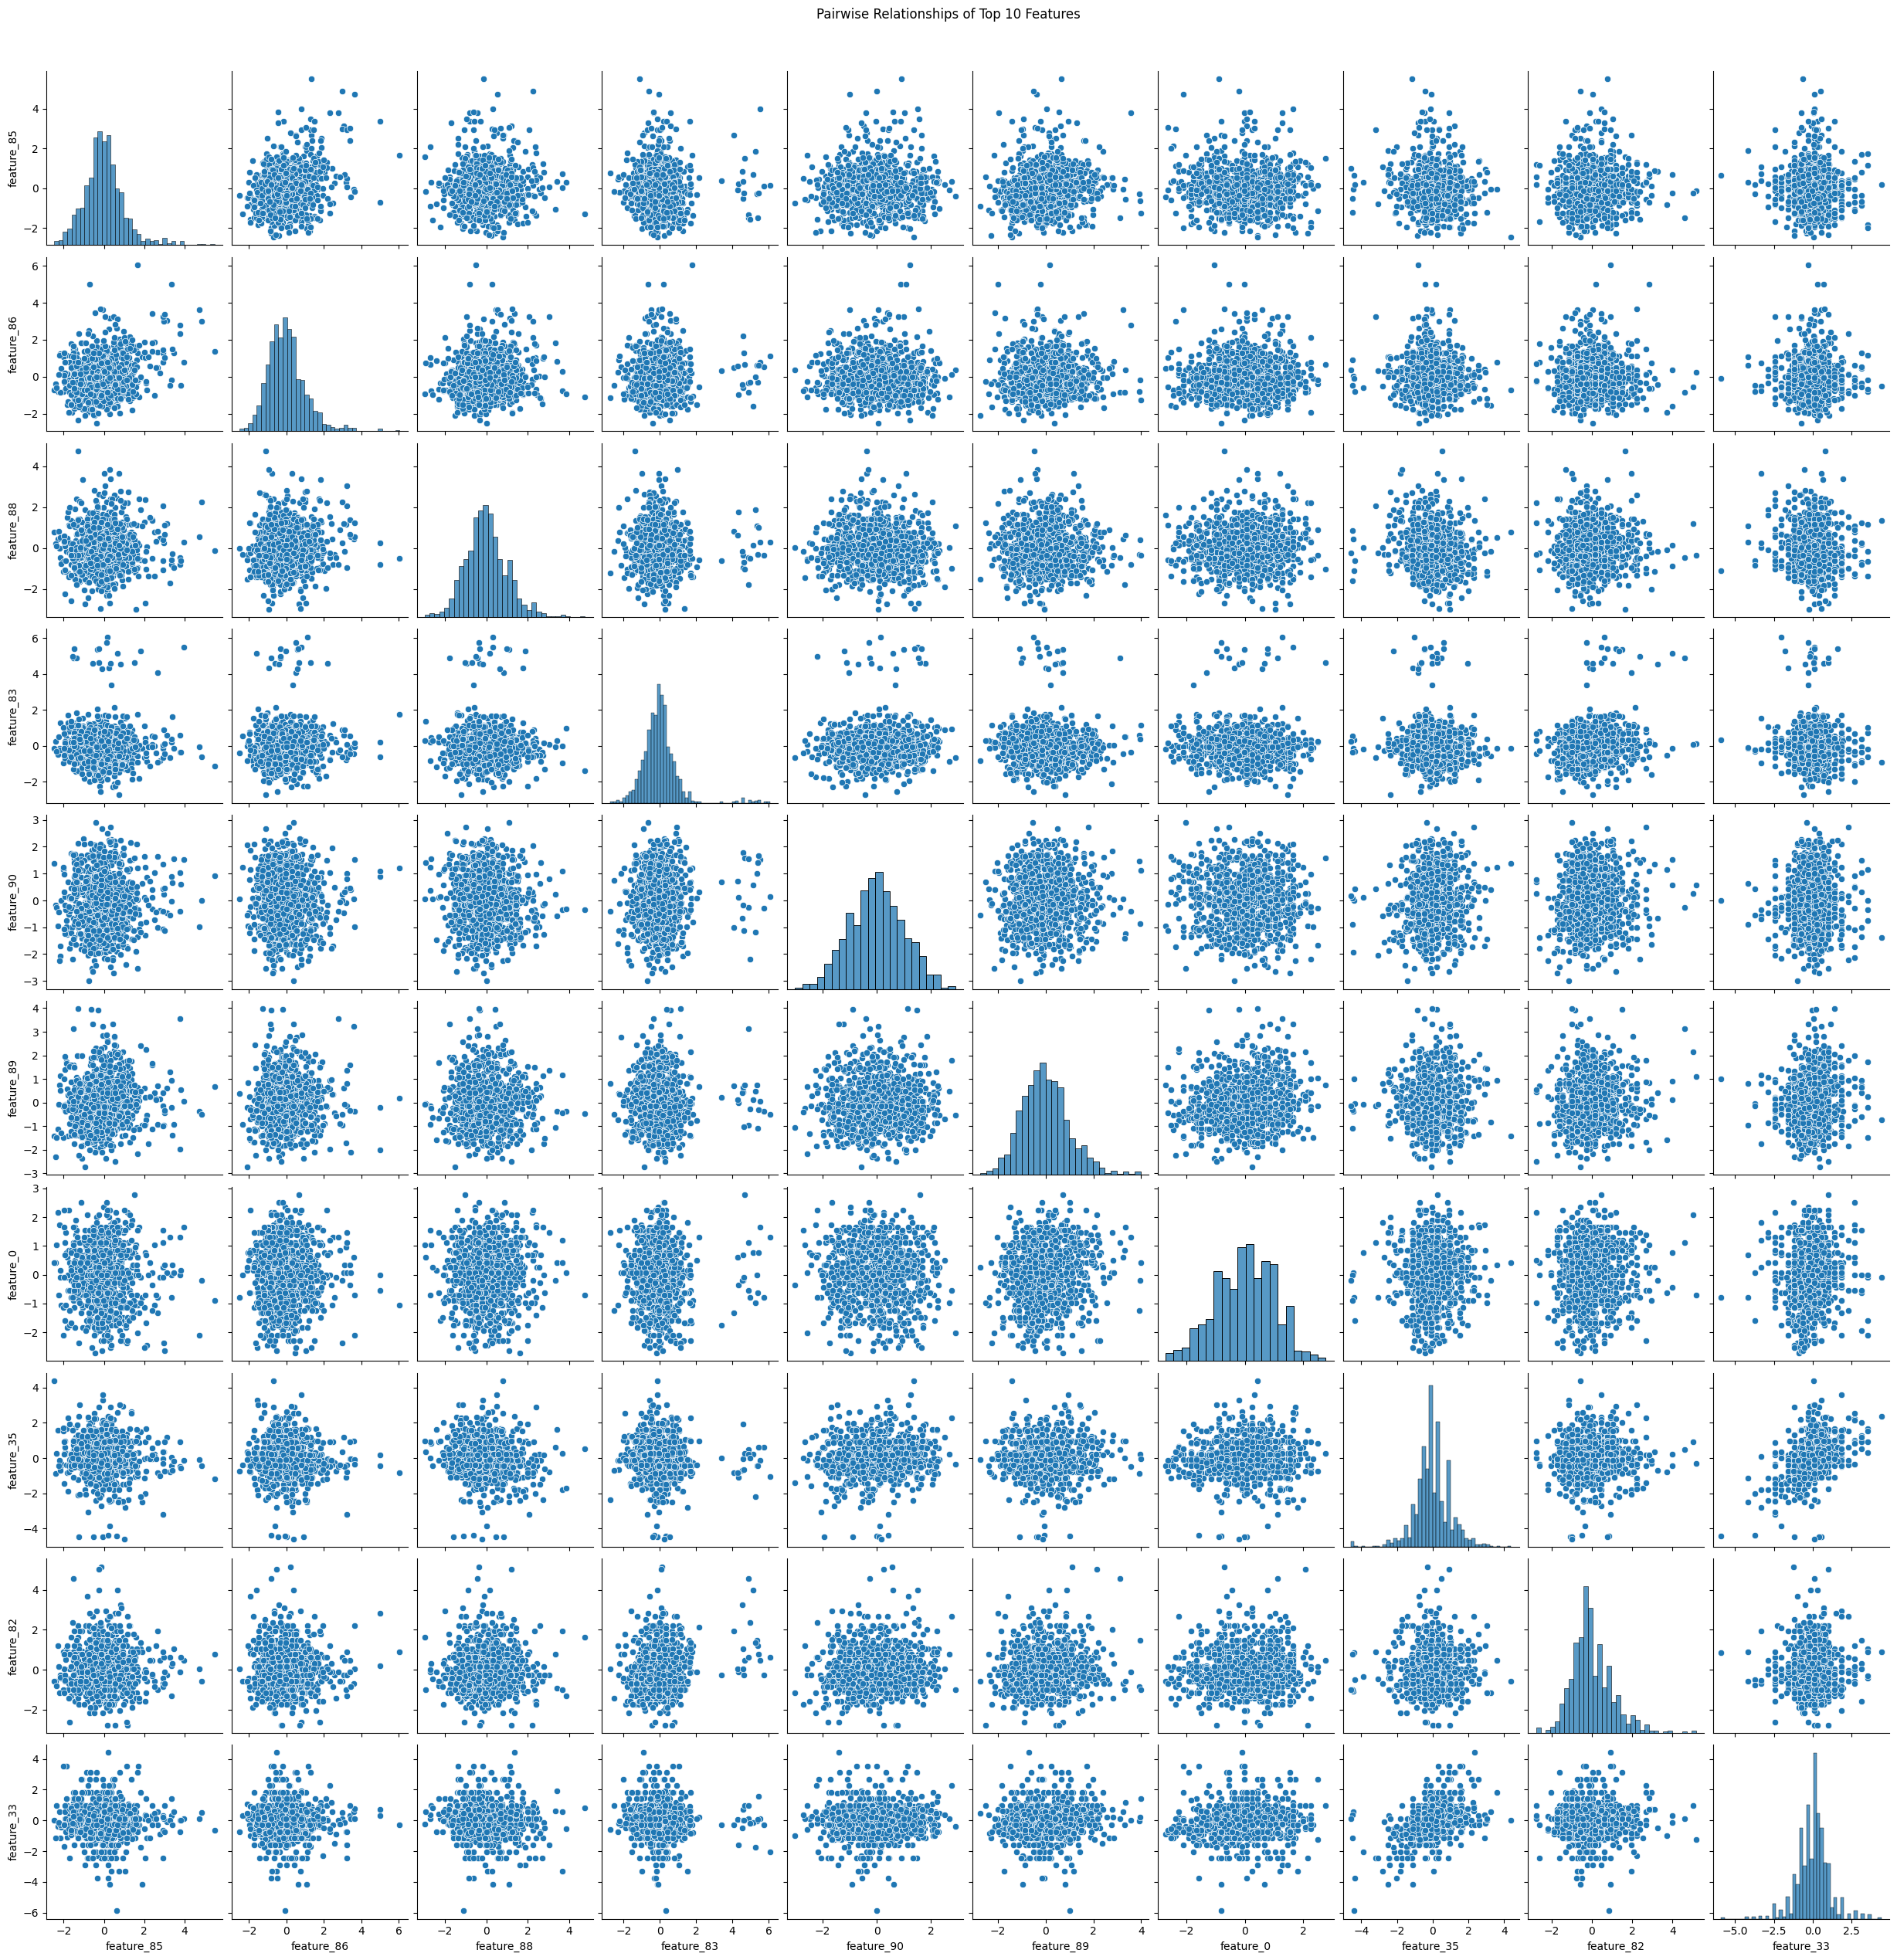

In [ ]:
import seaborn as sns
# Correlation matrix of the top 10 features
top_10_features_names = [name for name, _ in top_features]
# Creating a DataFrame with only the top 10 features
X_top_10_features = X_train_df[top_10_features_names]
corr_matrix_top_10 = X_top_10_features.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_top_10, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()

# Plotting the pairplots for the top 10 features
sns.pairplot(X_top_10_features)
plt.suptitle('Pairwise Relationships of Top 10 Features', y=1.02)  # Adjust title position
plt.show()

from here we can find that the features we picked using GBC are all weak correlated to each other, we can keep them all.

This visualization helps identify patterns, trends, and potential outliers across different feature combinations. The diagonal shows the distribution of each feature, providing insight into skewness or multimodality.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-54-a476841be39d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top_10_features['cluster'] = kmeans.labels_


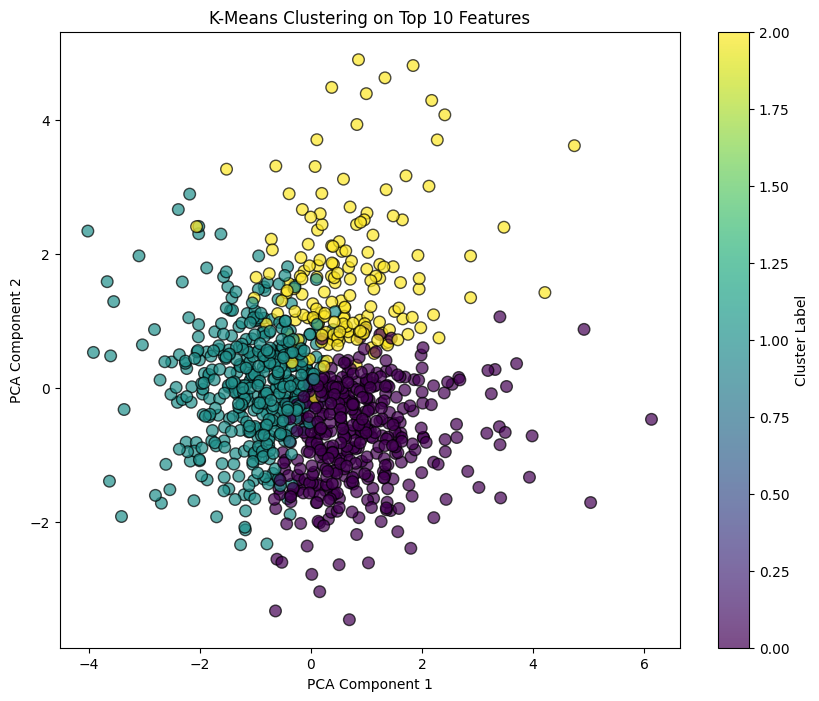

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_top_10_features)
X_top_10_features['cluster'] = kmeans.labels_
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_top_10_features.drop('cluster', axis=1))

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=X_top_10_features['cluster'], cmap='viridis', marker='o', edgecolor='k', s=70, alpha=0.7)
plt.title('K-Means Clustering on Top 10 Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

The purple cluster is centered around the origin of the PCA component axes  suggest that these data points have less variation.

The yellow cluster is the most dispersed and seems to be spread along the PCA Component 1 axis. The dispersion suggests this group is quite heterogeneous compared to the other clusters, or it may contain outliers. But l still prefer to keep all the data even they might contains outliers